# Dataloader

In [ ]:
# Dataloader class for USA_segmentation folder
# train, validation and test split
# data augmentation from torchvision.transforms
# takes in the file RGB and NIR channels and outputs a tensor of shape (batch_size, 4, height, width)
"""tree -L 2
            .
            ├── README.md
            ├── USA_segmentation
            │   ├── NRG_images (444 files)
            │       ├── NRG_ar037_2019_n_06_04_0.png
            │       ├── ...
            │   ├── RGB_images (444 files)
            │       ├── RGB_ar037_2019_n_06_04_0.png
            │       ├── ...
            │   └── masks (444 files)
            │       ├── mask_ar037_2019_n_06_04_0.png
            │       ├── ...
            └── main.ipynb
"""
#from dataset import USASegmentationDataset
# outsourced for multi-processing

import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


class USASegmentationDataset(Dataset):
    def __init__(self, rgb_paths, nir_paths, mask_paths, pil_transform=None, tensor_transform=None):
        self.rgb_paths = rgb_paths
        self.nir_paths = nir_paths
        self.mask_paths = mask_paths
        self.pil_transform = pil_transform
        self.tensor_transform = tensor_transform

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_img = Image.open(self.rgb_paths[idx]).convert("RGB")
        nir_img = Image.open(self.nir_paths[idx]).convert("L")
        mask_img = Image.open(self.mask_paths[idx]).convert("L")

        # Apply PIL transforms (geometric augmentations) BEFORE tensor conversion
        if self.pil_transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            rgb_img = self.pil_transform(rgb_img)
            torch.manual_seed(seed)
            nir_img = self.pil_transform(nir_img)
            torch.manual_seed(seed)
            mask_img = self.pil_transform(mask_img)

        # Convert to tensors
        rgb_tensor = T.ToTensor()(rgb_img)    # (3, H, W)
        nir_tensor = T.ToTensor()(nir_img)    # (1, H, W)
        mask_tensor = T.ToTensor()(mask_img)  # (1, H, W)
        
        # Combine RGB and NIR channels
        image_4ch = torch.cat([rgb_tensor, nir_tensor], dim=0)  # (4, H, W)

        # Apply tensor transforms (color augmentation) AFTER tensor conversion
        if self.tensor_transform:
            image_4ch = self.tensor_transform(image_4ch)

        # Process mask: squeeze channel dim and convert to binary long tensor
        mask_tensor = mask_tensor.squeeze(0)  # (H, W)
        mask_tensor = (mask_tensor > 0.5).long()

        return image_4ch, mask_tensor


def get_image_pairs(root_dir):
    rgb_dir = os.path.join(root_dir, "RGB_images")
    nir_dir = os.path.join(root_dir, "NRG_images")
    mask_dir = os.path.join(root_dir, "masks")

    rgb_paths = sorted(glob.glob(os.path.join(rgb_dir, "*.png")))
    nir_paths = sorted(glob.glob(os.path.join(nir_dir, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    assert len(rgb_paths) == len(nir_paths) == len(mask_paths), "Mismatch in file counts"

    return rgb_paths, nir_paths, mask_paths


def build_loaders(root_dir, batch_size=8, val_ratio=0.1, test_ratio=0.2, augment=False):
    rgb_paths, nir_paths, mask_paths = get_image_pairs(root_dir)

    # First split: separate test set
    temp_data = list(zip(rgb_paths, nir_paths, mask_paths))
    train_val_data, test_data = train_test_split(
        temp_data, test_size=test_ratio, random_state=42
    )
    
    # Second split: separate train and validation
    train_data, val_data = train_test_split(
        train_val_data, test_size=val_ratio / (1 - test_ratio), random_state=42
    )
    
    # Unpack the data
    train_rgb, train_nir, train_mask = zip(*train_data)
    val_rgb, val_nir, val_mask = zip(*val_data)
    test_rgb, test_nir, test_mask = zip(*test_data)

    # Convert tuples back to lists
    train_rgb, train_nir, train_mask = list(train_rgb), list(train_nir), list(train_mask)
    val_rgb, val_nir, val_mask = list(val_rgb), list(val_nir), list(val_mask)
    test_rgb, test_nir, test_mask = list(test_rgb), list(test_nir), list(test_mask)

    # PIL transforms (geometric augmentations - applied to PIL Images)
    # Note: Resize is REQUIRED to ensure all images have the same size for batching
    base_transforms = [T.Resize((256, 256))]  # Resize all images to 256x256
    
    if augment:
        base_transforms.extend([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
        ])
    
    pil_transform = T.Compose(base_transforms)

    # Tensor transforms (color/intensity augmentations - applied to tensors)
    tensor_transform = T.Compose([
        #T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # only works in RGB channels
        # You can add normalization here if needed
        T.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.25])
    ]) if augment else None

    train_dataset = USASegmentationDataset(
        train_rgb, train_nir, train_mask, 
        pil_transform=pil_transform, 
        tensor_transform=tensor_transform
    )
    val_dataset = USASegmentationDataset(
        val_rgb, val_nir, val_mask, 
        pil_transform=T.Resize((256, 256)),  # Resize validation images too
        tensor_transform=None
    )
    test_dataset = USASegmentationDataset(
        test_rgb, test_nir, test_mask, 
        pil_transform=T.Resize((256, 256)),  # Resize test images too
        tensor_transform=None
    )

    return {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
        "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
        "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    }



# UNet

In [72]:
# implementing UNet for dead tree segmentation
import torch
import torchvision.transforms.functional
from torch import nn
import torch.optim as optim
from tqdm import tqdm

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        """first conv layer"""
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        """second conv layer"""
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2=nn.ReLU()

    def forward(self, x: torch.Tensor):
        """apply 2 conv layers and activations"""
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

class DownSample(nn.Module):
    """each step in this contracting path down-samples the feature map with a 2x2 max pooling layer"""
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

class UpSample(nn.Module):
    """contrariwise, each step in this expansive path up-samples the feature map with a 2x2 up convolution"""
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

class CropAndConcat(nn.Module):
    """
       at every step in the expansive path, the corresponding feature map (FM)
       from the contracting path is concatenated with the current feature map
    """
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2],x.shape[3]]) # corresponding feature map from contracting path
        x = torch.cat([x, contracting_x], dim=1) # the current FM in expansive path
        return x

class UNet(nn.Module):
    """in_channels = number of channels in the input image
    out_channels = number of channels in the result feature map"""
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(in_channels, 64), (64,128), (128,256), (256,512)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        self.middle_conv = DoubleConvolution(512, 1024)
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(1024,512), (512,256),(256,128),(128,64)]])
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(1024,512),(512,256),(256,128),(128,64)]])
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        self.final_conv = nn.Conv2d(64,out_channels, kernel_size=1)

    def forward(self, x:torch.Tensor):
        """x = input image"""
        pass_through = [] # collects outputs of contracing path for later concatenation with the expansive path
        for i in range(len(self.down_conv)): # contracting path
            x = self.down_conv[i](x)
            pass_through.append(x)
            x = self.down_sample[i](x)
        x = self.middle_conv(x)
        for i in range(len(self.up_conv)): # expansive path
            x = self.up_sample[i](x)
            x = self.concat[i](x, pass_through.pop())
            x = self.up_conv[i](x)
        x = self.final_conv(x)
        return x



## setting the stage. loss fn, device backend, etc.

In [73]:
loaders = build_loaders("USA_segmentation", batch_size=8, augment=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=2).to(device)# using 4 channels (RGB + NIR) and 2 outputs for dead and healthy trees

criterion = nn.CrossEntropyLoss()# same as original paper (we are doing semantic segmentation)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## training; tqdm

In [74]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # (B, C, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


In [77]:
# training loop
num_epochs = 3
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, loaders['train'], optimizer, criterion)
    val_loss = evaluate(model, loaders['val'], criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
test_loss = evaluate(model, loaders['test'], criterion)
print(f"Test Loss: {test_loss:.4f}")


Validation: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


Epoch [1/3], Train Loss: 0.0616, Val Loss: 0.0957


Validation: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch [2/3], Train Loss: 0.0605, Val Loss: 0.1043


Validation: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch [3/3], Train Loss: 0.0564, Val Loss: 0.1275


Validation: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.45it/s]

Test Loss: 0.1086


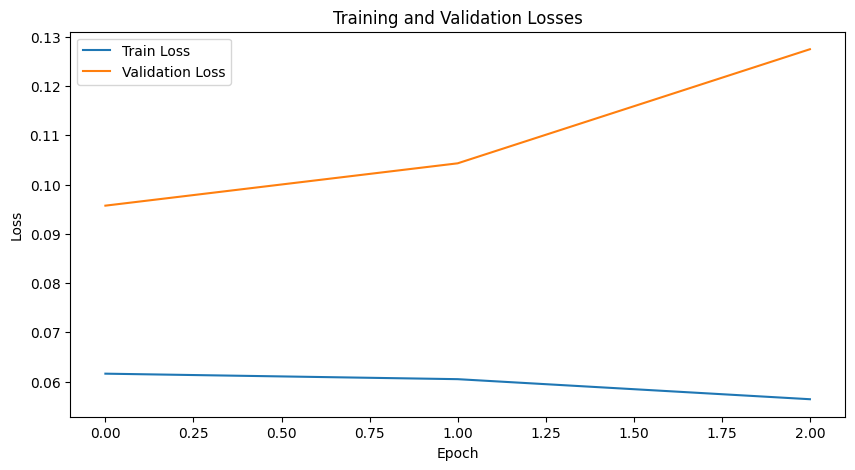

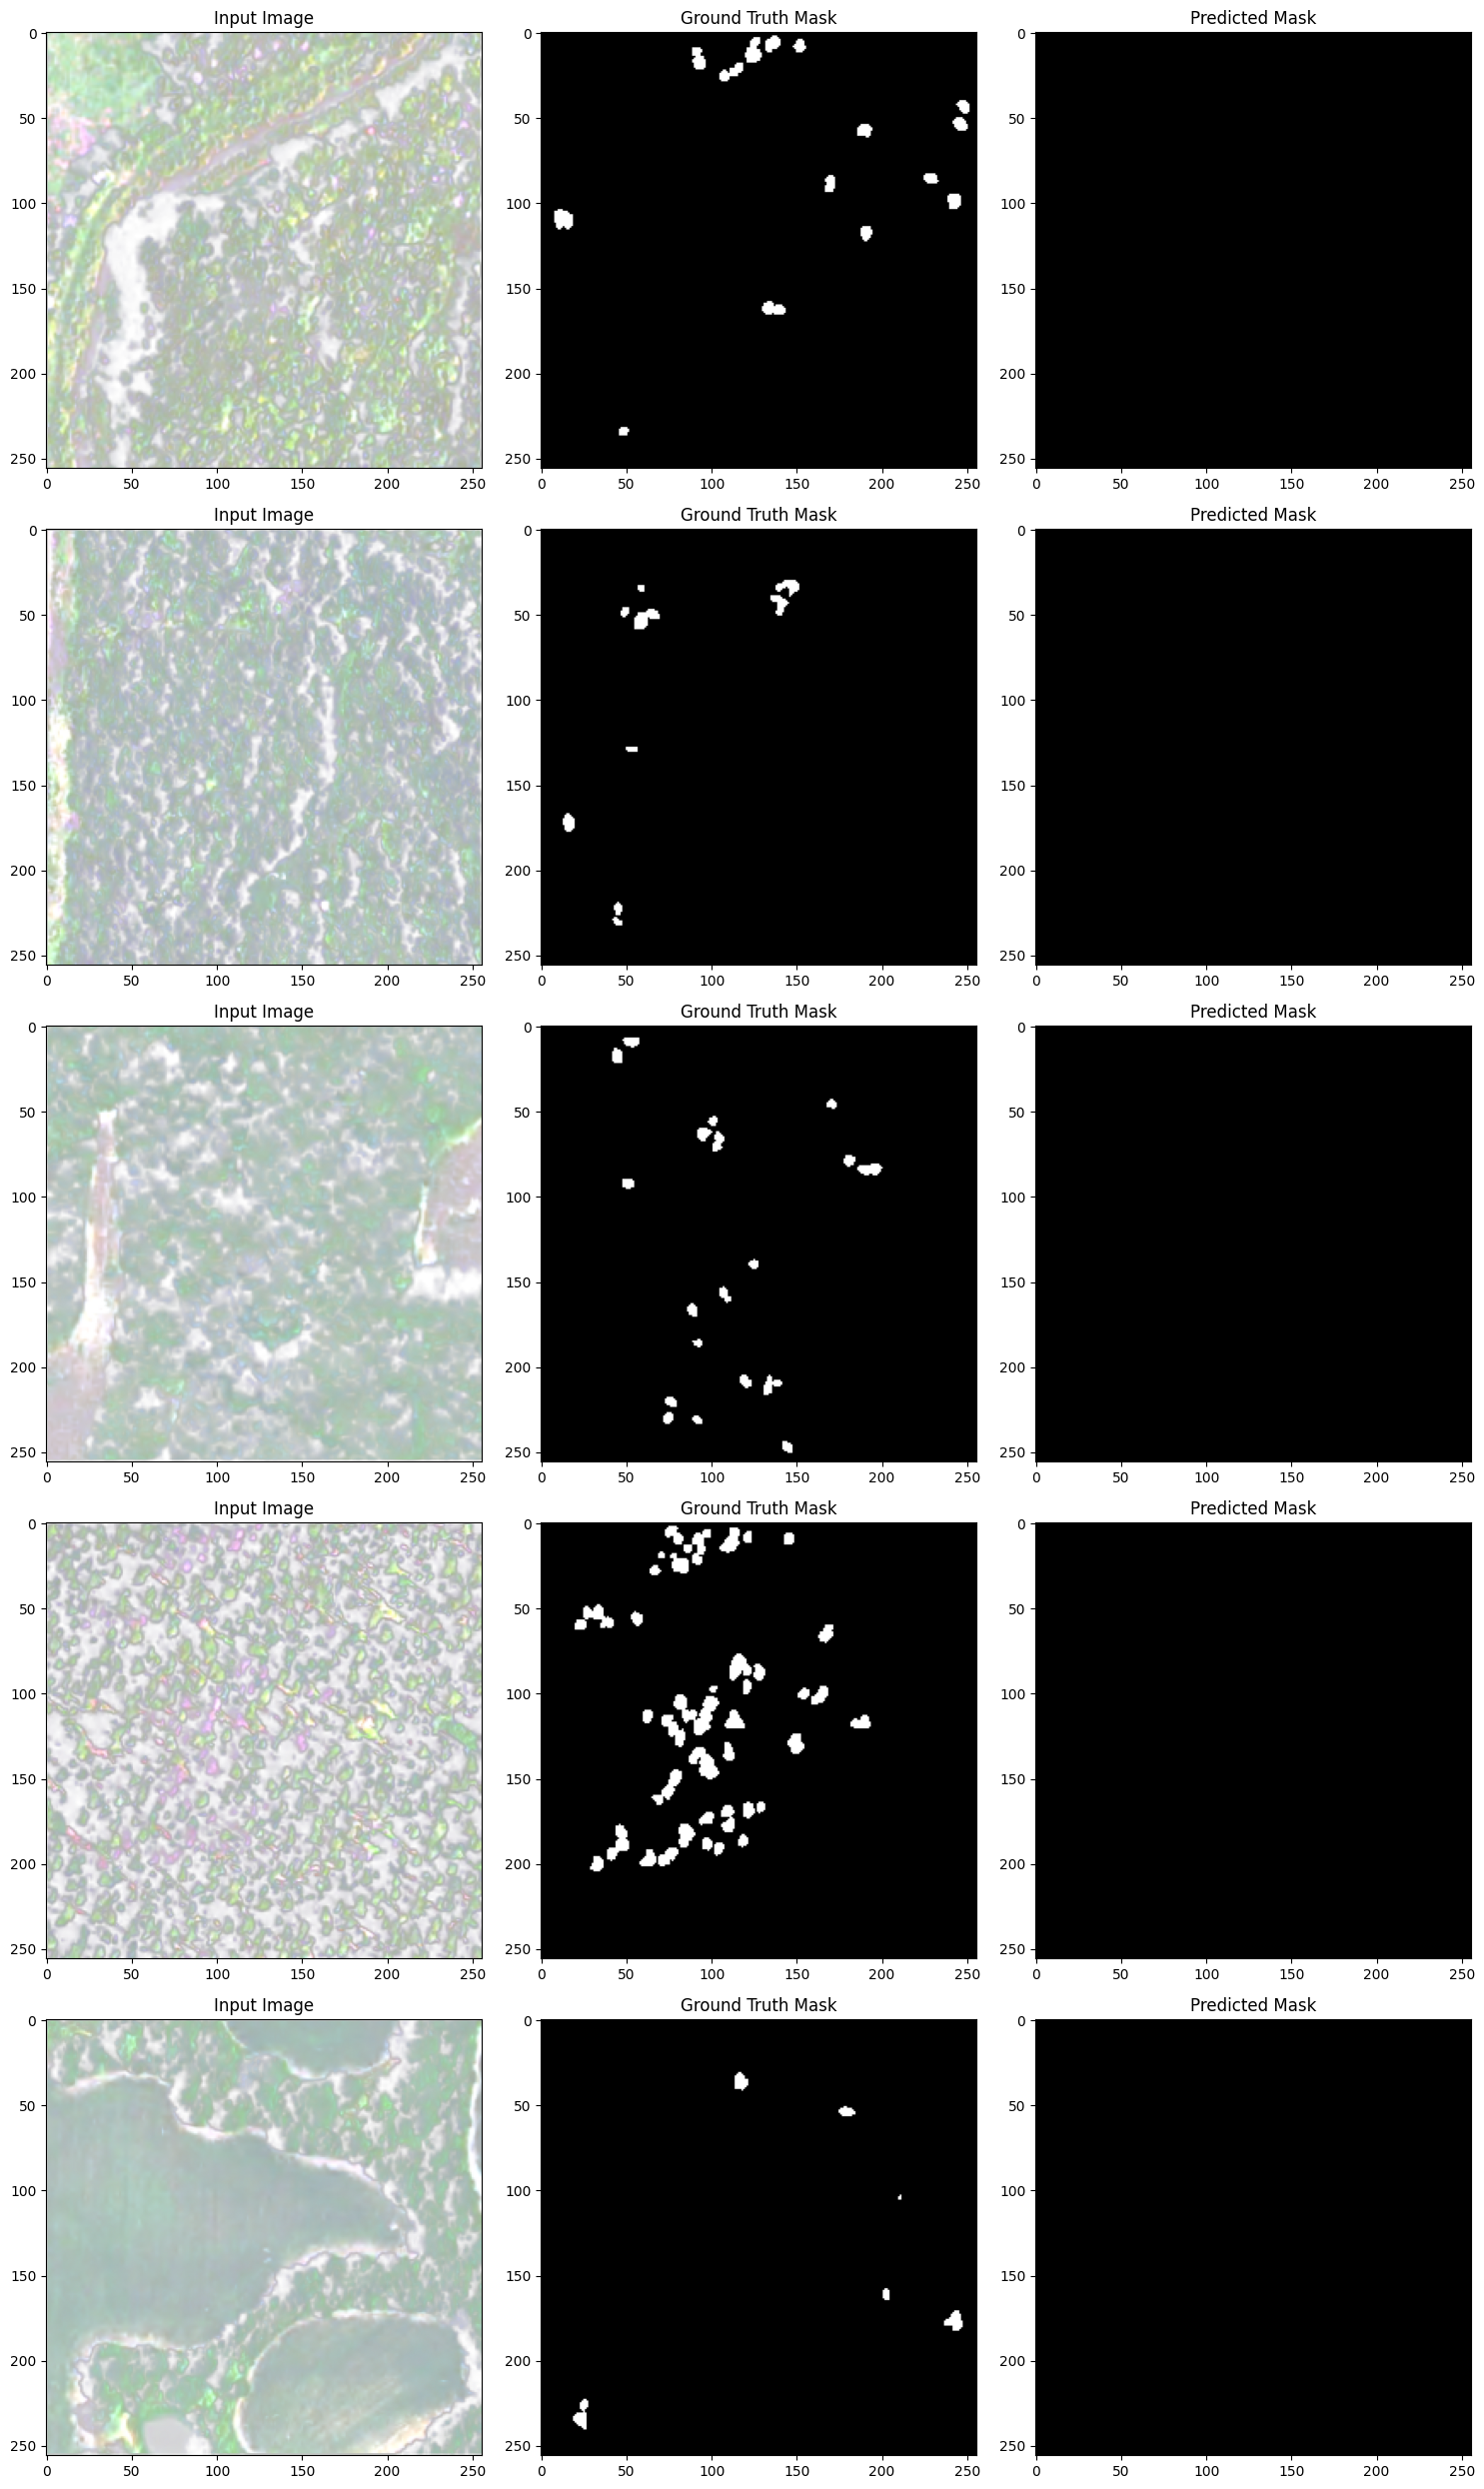

In [78]:
# plotting losses and predictions
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
def plot_predictions(model, dataloader, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1)  # Get predicted class indices

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 0].set_title('Input Image')
        axes[i, 1].imshow(masks[i].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 2].imshow(outputs[i].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()
plot_losses(train_losses, val_losses)
plot_predictions(model, loaders['test'], num_images=5)

# CNN

In [ ]:
# CNN 